# <center> New York Rentals - Short Term Profitablity Analysis </center>

# Introduction

The goal of this project is to analyze which zipcodes would be profitable to invest in New York and the scope of the analysis is restricted to 2 bedroom properties for now. I will be using data from Airbnb (Airbnb listings in the New York area) and Zillow (Time Series data of median house prices) for this analysis.

# Approach:



# Assumptions made:

1. Occupancy rate of 75% for Airbnb rentals.
2. The investor will pay for the property in cash (i.e. no mortgage/interest rate will need to be accounted for).
3. The time value of money discount rate is 0% (i.e. $1 today is worth the same 100 years from now).
4. All properties and all square feet within each locale can be assumed to be homogeneous (i.e. a 1000 square foot property in a locale such as Bronx or Manhattan generates twice the revenue and costs twice as much as any other 500 square foot property within that same locale.)
5. Price listed in the Airbnb data is the final price that the customer pays (i.e. No discounts).
6. Cleaning fee, Security deposit and costs related to extra beds are not considered for the sake of simplicity.
7. Annual Revenue (Rent) is calculated by, Annual Revenue = Price per night * occupancy rate * availability_365. Rent increases by 5% every year
8. Investor buys the properties in 6th month of 2017 (2017-06). (i.e. Investment cost = Latest Median list price)
9. Only zipcodes with more than 15 listings are considered for analysis. Zipcodes with more than 15 listings are considered to be zipcodes with high demand.

# Importing necessary packages

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import to_datetime
import warnings
warnings.filterwarnings('ignore')
import os
import glob
from fbprophet import Prophet

# Functions used for the Analysis

In [2]:
""" 
function to merge Airbnb listings data from a local directory

Input Parameters:
1. path - local path of the listings data
2. fp - variable to hold the pattern of the filename to be read

Output:
Returns a dataframe
"""

def merge_files_wo_header(path, fp):
            
    all_files = glob.glob(os.path.join(path, fp))     # os.path.join makes the concatenation OS independent

    df_from_each_file = (pd.read_csv(f,header=None) for f in all_files) # loop through all files in the local directory
    concatenated_df   = pd.concat(df_from_each_file) # concatenating all the files

    return concatenated_df

In [3]:
""" 
function to make the first row of the dataframe as a header and resetting the index

Input Parameters:
Dataframe to be formatted

Output:
Returns the formatted dataframe
"""

def make_df_firstrow_header(df): 
    df = df.rename(columns=df.iloc[0]).drop(df.index[0]) # makes the first row of df as header
    df.reset_index(inplace=True,drop=True)
    
    return df

In [4]:
""" 
function to filter airbnb data

Input Parameters:
1. df - Dataframe to be filtered
2. state - list of states to be filtered
3. bedrooms - list of bedrooms to be filtered

Output:
Returns the filtered dataframe
"""


def filter_airbnb_data(df,state,bedrooms):
    
    df = df[df['state'].isin(state)] # filters the df based on state
    df = df[df['bedrooms'].isin(bedrooms)] # filters the df based on bedrooms
    df.reset_index(inplace=True,drop=True)
    
    return df

In [5]:
""" 
function to remove text columns 

Input Parameters:
1. df - Dataframe to be filtered
2. length - threshold length for removing columns based on the length of values in a column 

Output:
Returns the filtered dataframe
"""

def remove_text_columns(df,length):
    
    """
    for loop to loop through all the columns in the dataset and drop the column 
    if the length of the value in column greater than threshold value
    """
    
    for col in df.columns:
        if (type(df[col][0]) is str) and (len(df[col][0]) > length):
            df.drop(col,inplace=True, axis=1)
    
    return df

In [6]:
""" 
function to remove columns with specific column names or patterns in column names

Input Parameters:
1. df - Dataframe to be filtered
2. patterns - list which holds the patterns to be removed

Output:
Returns the filtered dataframe
"""

def remove_columns_w_patterns(df,patterns):
    
    """
    for loop to loop through all the columns in the dataset and drop the column 
    if the column name contains a specific pattern 
    """
    for val in patterns:
        df.drop(df.filter(regex=val).columns, axis=1, inplace=True)
    
    return df

In [7]:
""" 
function to remove columns with high percentage of null values 

Input Parameters:
1. df - Dataframe to be filtered
2. perc - threshold percentage for removing columns based on the length of values in a column 

Output:
Returns the filtered dataframe
"""

def remove_null_columns(df,perc):
    min_count =  int((len(df) * perc)/100) # computes the number of null values allowed in a column based on the given percentage
    df.dropna(axis=1, thresh=min_count,inplace=True)
    
    return df

In [8]:
""" 
function to filter Zillow data

Input Parameters:
1. df - Dataframe to be filtered
2. state - list of states to be filtered
3. cols - list of columns to be filtered

Output:
Returns the filtered dataframe
"""

def filter_zillow_data(df,state,cols):
    
    df = df[df['State'].isin(state)] # filters df based on state
    df = df.drop(columns=cols) # drops the columns from df based on user passed argument
    df = df.dropna(axis=1)
    df.rename(columns={'RegionName': 'zipcode'}, inplace=True)
    df.zipcode = df.zipcode.astype(str)
    df.reset_index(inplace=True,drop=True)
    
    return df

In [9]:
""" 
function to join 2 dataframes

Input Parameters:
1. df1 - Dataframe 1 to be joined
2. df2 - Dataframe 2 to be joined
3. join_type - contains a string on the type of join desired
4. join_on - contains a string on which column the join to be performed

Output:
Returns the joined dataframe
"""
def join_zillow_airbnb(df1,df2,join_type,join_on):
    
    df_join = pd.merge(df1, df2, how = join_type, on = join_on)
    return df_join

In [10]:
""" 
function to convert data from wide format to long format

Input Parameters:
1. df - Dataframe to be converted
2. ziplist = contains a list of columns to be converted to long format

Output:
Returns the transformed dataframe
"""
def zillow_transpose_long(df,ziplist):
    
     # convert the dataframe to long format
    df_t = df.T
    df_t.rename(columns=df.iloc[0], inplace = True)
    df_t.drop(['State'], inplace = True)
    df_t.reset_index(level=0, inplace=True)
    
    # function call to format the dataframe
    df_t = make_df_firstrow_header(df_t) 
    
    # for loop to filter the transposed dataframe based on the user passed list argument
    for val in df_t.columns.tolist():
        if val not in ziplist and val!='zipcode':
            df_t.drop(columns=val, axis=1, inplace=True)
    
    df_t.rename(columns={'zipcode': 'Time'}, inplace=True)
    
    return df_t

In [11]:
""" 
function to predict the future median house price

Input Parameters:
1. ztl - Dataframe to be converted
2. future = contains a list of values of future time periods

Output:
Returns the transformed dataframe with forecasted values
"""
def timeseries_forecast(ztl,future):
    
    # converting the dataframe to the required format to use the prophet algorithm
    df = pd.DataFrame()
    df['ds'] = ztl['Time']
    df['ds']= to_datetime(df['ds']) # converting the column to datetime format
    ztl = ztl.drop(columns='Time')
    final = pd.DataFrame()
    
    # for loop to loop through all the zipcodes in the dataframe and forecast future median house price
    for val in ztl.columns.tolist():
        df['y'] = ztl[val]
        
        # define the model
        model = Prophet()
        # fit the model
        model.fit(df)
        
        future = pd.DataFrame(future)
        future.columns = ['ds']
        future['ds']= to_datetime(future['ds'])
        
        # use the model to make a forecast
        forecast = model.predict(future)
        
        forecast['ds'] = forecast['ds'].dt.strftime('%Y-%m') # converting the datetime format to the required format
        forecast_zip = forecast[['ds','yhat']]
        forecast_zip = forecast_zip.T # converting the long format dataframe to wide format
        
        forecast_zip = make_df_firstrow_header(forecast_zip) # function call
        
        final = final.append(forecast_zip) # append the forecasted prices for each zipcode
    
    final['zipcode'] = ztl.columns.tolist()
    return final

In [12]:
""" 
function to predict the breakeven period for each zipcode

Input Parameters:
1. forecast - contains the forecasted dataframe
2. listings - contains the listings count for each zipcode
3. listings_count - contains a integer threshold value to filter the zipcodes
4. price_inc_rate - rate at which annual revenue increases per year

Output:
Returns the transformed dataframe
"""
def breakeven(forecast,listings,listings_count,price_inc_rate):
    # group by to get median house price of each zipcode
    df = forecast.groupby('zipcode')[['Annual Revenue','Median_price_latest']].median().apply(np.ceil)
    df = pd.DataFrame(df1)
    df.reset_index(level=0, inplace=True)
    
    # creating a colum to hold payback period
    df['Payback_period'] = 0.0
    
    # filterting the dataframe based on listings count for each zipcode
    listings = listings[listings['count']>listings_count]
    
    # function call to join listings and groupby dataframes
    df = join_zillow_airbnb(df,listings,'inner','zipcode')
    
    # for loop to itreate through the dataframe
    for idx,row in df.iterrows():
        rev = df['Annual Revenue'].loc[idx]
        mpl = df['Median_price_latest'].loc[idx]

        year = 0.0
        total_rev = 0
        
        # while loop to calculate the breakeven period for each zipcode
        while(total_rev<=mpl):
            rev = rev * (1 + price_inc_rate/100)
            total_rev = total_rev + rev
            year = year + 1

        year = year - ((total_rev-mpl)/rev)

        df['Payback_period'].loc[idx] = year
        df.Payback_period = df.Payback_period.round(2) # rounds the column to decimal places
    
    return df

In [13]:
""" 
function to predict the ROI for each zipcode

Input Parameters:
1. forecast - contains the forecasted dataframe
2. listings - contains the listings count for each zipcode
3. listings_count - contains a integer threshold value to filter the zipcodes
4. price_inc_rate - rate at which annual revenue increases per year

Output:
Returns the transformed dataframe
"""
def roi(forecast,listings,listings_count,price_inc_rate):
    forecast['forecast_5yr'] = forecast['forecast_5yr'].astype(int) # converting the forcasted values to int
    
    # group by to get median house price, 5 year forecast of each zipcode
    df = forecast.groupby('zipcode')[['Annual Revenue','Median_price_latest','forecast_5yr']].median().apply(np.ceil)
    df.reset_index(level=0, inplace=True)
    
    # filterting the dataframe based on listings count for each zipcode
    listings = listings[listings['count']>listings_count]
    
    # for loop to itreate through the dataframe
    df = join_zillow_airbnb(df,listings,'inner','zipcode')
    
    # computing the ROI % for each zipcode
    df['ROI'] = (df['forecast_5yr'] + (df['Annual Revenue'] * ((1 + price_inc_rate/100)**5)) - df['Median_price_latest']) *100 / df['Median_price_latest']
    df.ROI = df.ROI.round(2) # rounds the column to decimal places
    
    return df

In [14]:
""" 
function to annotate scatter plot

Input Parameters:
1. x - x coordinate
2. y - y coordinate
3. value - value to be printed
4. ax = axis

Output:
Returns the transformed dataframe
"""

def annotate_scatterplot(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y']+1.25, str(point['val']), size='xx-large',ha = 'center')

# Importing data

In [15]:
path = r'D:\Sem 4\Capital One\DA-master\DA-master' # Path where the local csv files reside
filename_pattern = "listings*.csv" # common pattern in your filename

Airbnb = merge_files_wo_header(path,filename_pattern) #function call

In [16]:
Airbnb = make_df_firstrow_header(Airbnb) #function call
Airbnb.shape

(40750, 95)

In [17]:
Airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40750 entries, 0 to 40749
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   id                                40750 non-null  object
 1   listing_url                       40750 non-null  object
 2   scrape_id                         40750 non-null  object
 3   last_scraped                      40750 non-null  object
 4   name                              40715 non-null  object
 5   summary                           39135 non-null  object
 6   space                             27879 non-null  object
 7   description                       40731 non-null  object
 8   experiences_offered               40750 non-null  object
 9   neighborhood_overview             23628 non-null  object
 10  notes                             14606 non-null  object
 11  transit                           25459 non-null  object
 12  access            

In [18]:
Zillow = pd.read_csv('Zip_Zhvi_2bedroom.csv') # reading Zillow data
Zillow.head() # inspecting the head of dataset

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
0,61627,10013,New York,NY,New York,New York,1744,NaN,NaN,NaN,...,3347100,3305500,3261100,3244000.0,3231400,3183300,3160200,3193500,3262200,3316500
1,61628,10014,New York,NY,New York,New York,379,NaN,NaN,NaN,...,2480800,2443200,2430100,2452900.0,2451200,2441900,2460900,2494900,2498400,2491600
2,61625,10011,New York,NY,New York,New York,15,NaN,NaN,NaN,...,2354000,2355500,2352200,2332100.0,2313300,2319600,2342100,2365900,2419700,2480400
3,97515,94024,Los Altos,CA,San Jose,Santa Clara,4335,419500.0,422300.0,430400.0,...,2330300,2302700,2269300,2263600.0,2279300,2302700,2321700,2351200,2371500,2378100
4,97519,94028,Portola Valley,CA,San Francisco,San Mateo,7158,NaN,NaN,NaN,...,2350800,2336500,2317200,2313800.0,2324200,2317300,2294500,2296300,2329400,2358300


In [19]:
Zillow.shape

(8946, 262)

# Filterting Data - NYC 2 bedrooms Airbnb

For this analysis, i will be focusing on 2 bedroom property listings in the New York Area. Before filtering the dataset, i want to inspect state and bedrooms column to make sure we have clean data to work with.

## Quality Check 

## 1. Inspecting State column

In [20]:
Airbnb.state.isnull().sum()

0

In [21]:
Airbnb.state.value_counts()

NY          40741
ny              5
VT              1
NJ              1
MP              1
New York        1
Name: state, dtype: int64

In [22]:
Airbnb[Airbnb['state'] == 'VT'].neighbourhood_group_cleansed

29968    Manhattan
Name: neighbourhood_group_cleansed, dtype: object

In [23]:
Airbnb[Airbnb['state'] == 'NJ'].neighbourhood_group_cleansed

29689    Manhattan
Name: neighbourhood_group_cleansed, dtype: object

In [24]:
Airbnb[Airbnb['state'] == 'MP'].neighbourhood_group_cleansed

3174    Brooklyn
Name: neighbourhood_group_cleansed, dtype: object

Observations: 
1. The state column mostly contains 'NY' values. But it also has other values such as ny, New York, MP, NJ, VT and so on
2. Upon, further inspection of the neighbourhood_cleansed column for these states, I found that these listings were of Manhattan and Brooklyn. This could be simply erroneous data and should be cleaned appropriately.

So, I decided to change all the values to 'NY' in the state column.

In [25]:
Airbnb['state']= 'NY' # cleaning the values of state column
Airbnb.state.value_counts() # inspecting the state column after cleaning

NY    40750
Name: state, dtype: int64

## 2. Inspecting Bedrooms column

In [26]:
Airbnb.bedrooms.isnull().sum()

69

In [27]:
Airbnb = Airbnb[Airbnb['bedrooms'].notna()] #removing null values 
Airbnb['bedrooms'] = Airbnb['bedrooms'].astype("str") # converting bedrooms column values

Airbnb.bedrooms = Airbnb.bedrooms.replace("0.0","0")
Airbnb.bedrooms = Airbnb.bedrooms.replace("1.0","1")
Airbnb.bedrooms = Airbnb.bedrooms.replace("2.0","2")
Airbnb.bedrooms = Airbnb.bedrooms.replace("3.0","3")
Airbnb.bedrooms = Airbnb.bedrooms.replace("4.0","4")
Airbnb.bedrooms = Airbnb.bedrooms.replace("5.0","5")
Airbnb.bedrooms = Airbnb.bedrooms.replace("6.0","6")
Airbnb.bedrooms = Airbnb.bedrooms.replace("7.0","7")
Airbnb.bedrooms = Airbnb.bedrooms.replace("8.0","8")
Airbnb.bedrooms = Airbnb.bedrooms.replace("9.0","9")
Airbnb.bedrooms = Airbnb.bedrooms.replace("10.0","10")

Airbnb['bedrooms'].value_counts()

1     30295
2      4892
0      3525
3      1458
4       375
5        87
6        29
7         8
8         7
10        3
9         2
Name: bedrooms, dtype: int64

In [28]:
print('2 Bedroom Airbnb listings:', "{:.2f}".format((4892/40750)*100),"%")

2 Bedroom Airbnb listings: 12.00 %


In [29]:
print('Erroneous data - Listed as 0 bedroom properties', "{:.2f}".format((3525/40750)*100),"%")

Erroneous data - Listed as 0 bedroom properties 8.65 %


Observations:

1. The bedroom column has 69 null values.
2. Data is not clean as the column has values like 2,2.0 and so on. This has to be cleaned before the next step.
3. 12% of listings are 2 bedroom properties in New York.
4. 8.65% of the values are 0 in the bedrooms column. This is erroneous data. So, we may have more than 12% of 2 bedrooms properties in New York and the above figure may not be an accurate representation of the actual world data.

Note: I have changed the format of bedrooms column to string because it will be easier to work with.

## Filtering Airbnb data

In [30]:
state = ['NY'] # list to store the state values which needs to be filtered
bedrooms = ['2'] # list to store the bedroom values which needs to be filtered

Airbnb = filter_airbnb_data(Airbnb,state,bedrooms) # function call to filter airbnb data
Airbnb.shape # shape after filtering airbnb data

(4892, 95)

Further inspection of other important columns in Airbnb data

## 3. Inspecting Neighbourhood group cleansed column

In [31]:
Airbnb.neighbourhood_group_cleansed.isnull().sum() # no null values

0

In [32]:
Airbnb.neighbourhood_group_cleansed.unique()

array(['Bronx', 'Queens', 'Staten Island', 'Brooklyn', 'Manhattan'],
      dtype=object)

## 4. Inspecting price column

In [33]:
Airbnb.price.isnull().sum() # no null values

0

In [34]:
Airbnb['price'].head() # inspecting head of price column

0    $130.00 
1    $150.00 
2    $200.00 
3    $250.00 
4     $79.00 
Name: price, dtype: object

In [35]:
Airbnb.replace({'[\$,]':''}, regex=True,inplace=True) # cleaning the price column by removing '$,\' sybmols'
Airbnb.price = Airbnb.price.astype("float") # changing the price column to float value
Airbnb.weekly_price = Airbnb.weekly_price.astype("float")
Airbnb.monthly_price = Airbnb.monthly_price.astype("float")

### 4.1 Visualizing the price distribution using a histogram

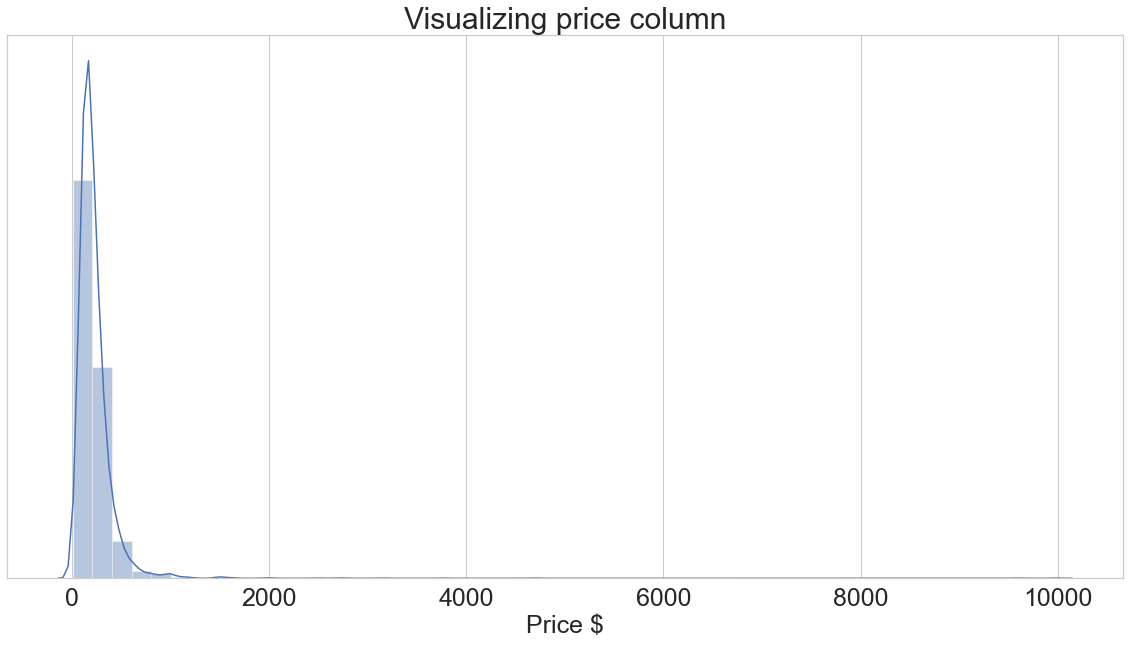

In [36]:
sns.set_theme(style="whitegrid") # set white grid background
plt.figure(figsize=(20,10))

sns.distplot(Airbnb['price']) # plot hostogram for price variable

# formatting ticks size
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

# setting title and labels
plt.title("Visualizing price column", loc='center',fontsize=30)
plt.xlabel('Price $',fontsize=25)

# hiding yticks
ax = plt.gca()
ax.axes.yaxis.set_visible(False)

Observations:
   
1. Price column is positively skewed. In such scenarios, median is a better measure of central tendency than mean since mean > median and it is resistent to outliers compared to mean.

### 4.2 Checking for the presence of outliers using boxplot

Text(0, 0.5, 'Neighbourhood group')

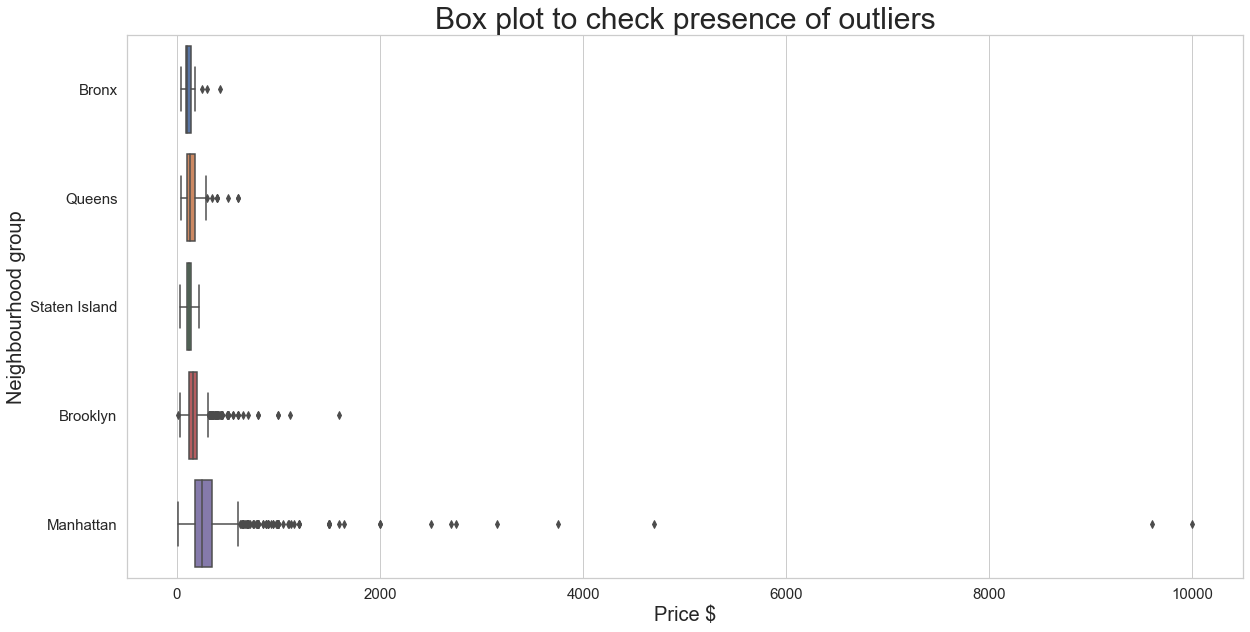

In [37]:
# Draw boxplot to check the presence of outliers
plt.figure(figsize=(20,10))
sns.set_theme(style="whitegrid")
sns.boxplot(x = Airbnb['price'], y= Airbnb['neighbourhood_group_cleansed'], showfliers=True)

# formatting ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# setting lablel and title
plt.title("Box plot to check presence of outliers", loc='center',fontsize=30)
plt.xlabel('Price $',fontsize=20)
plt.ylabel('Neighbourhood group',fontsize=20)

### 4.3 Removing outliers from manhattan column

In [38]:
manhattan = Airbnb[Airbnb['neighbourhood_group_cleansed']=='Manhattan'] # filtering manhattan listings

# computing Inter-Quartile_Range (IQR)
Q1 = manhattan.price.quantile(0.25)
Q3 = manhattan.price.quantile(0.75)
IQR = Q3 - Q1

# Printing upper and lower bound values
print('The upper bound value for price in the dataset is:', "{:.0f}".format(Q3 + 1.5 * IQR),"$")
print('The upper bound value for price in the dataset is:', "{:.0f}".format(Q3 - 1.5 * IQR),"$")

The upper bound value for price in the dataset is: 612 $
The upper bound value for price in the dataset is: 88 $


In [39]:
Airbnb = Airbnb[Airbnb['price']<2000] # removing columns with price < 2000$
Airbnb.shape 

(4882, 95)

Observations:

1. Manhattan neighbourhood has prices like 9999$. This has to be removed

Outlier Treatment - Approach:

1. The upperbound price for Manhattan is 612 dollars, so removing prices above that value would not be meaningful value as we will lose a lot of data. Instead, I will remove prices above 2000 dollars to retain as much data points as possible.

2. 10 data points have been removed

Note: The value of 2000 was arrived by referring through the Airbnb website and browsing through the prices for 2 bedroom Airbnb listings in New York. I was able to find rooms for 1600 $ per night in the Mahattan area. 

### 4.4 Boxplot after oulier treatment

Text(0, 0.5, 'Neighbourhood group')

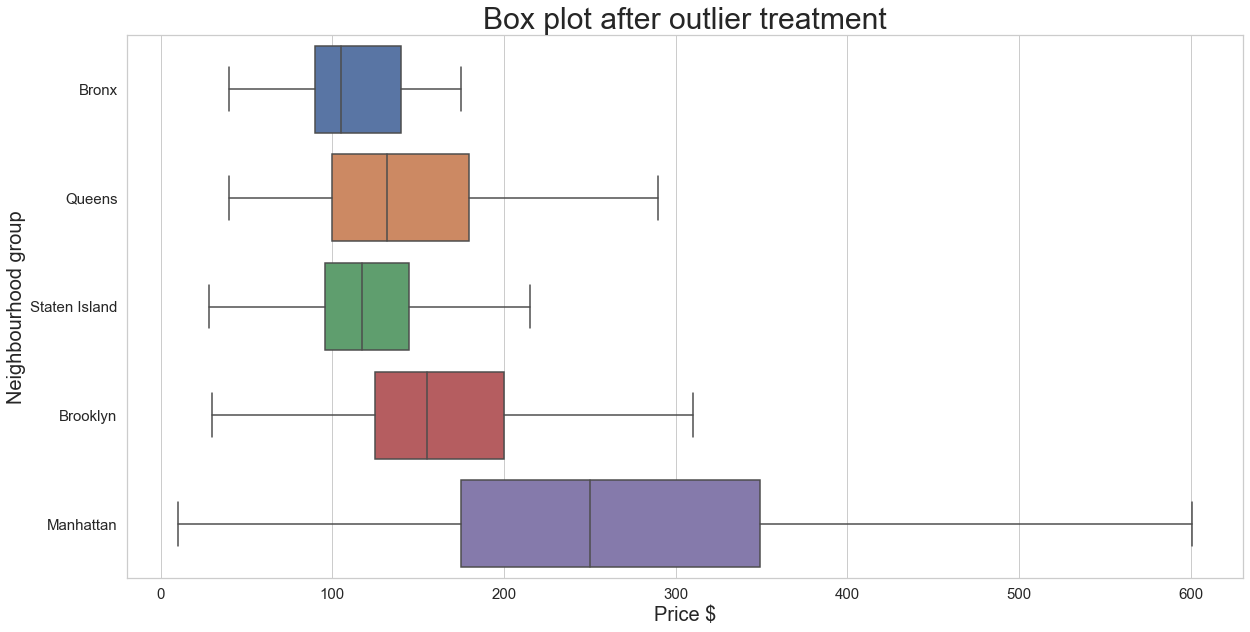

In [40]:
# Draw boxplot to check the presence of outliers
plt.figure(figsize=(20,10))
sns.set_theme(style="whitegrid")
sns.boxplot(x = Airbnb['price'], y= Airbnb['neighbourhood_group_cleansed'], showfliers=False)

# formatting tick size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# setting title and label
plt.title("Box plot after outlier treatment", loc='center',fontsize=30)
plt.xlabel('Price $',fontsize=20)
plt.ylabel('Neighbourhood group',fontsize=20)

### 4.5 Visualizing median rent prices of each neighbourhood

In [41]:
grouped_df = Airbnb.groupby('neighbourhood_group_cleansed')['price'].median() # creating a dataframe to visualize median rent
grouped_df = grouped_df.apply(np.ceil) # rounding off to the nearest decimal
grouped_df = pd.DataFrame(grouped_df) # converting to dataframe
grouped_df.reset_index(inplace=True) 
grouped_df

,neighbourhood_group_cleansed,price
0,Bronx,105.0
1,Brooklyn,155.0
2,Manhattan,250.0
3,Queens,132.0
4,Staten Island,118.0


Text(0, 0.5, 'Neighbourhood group')

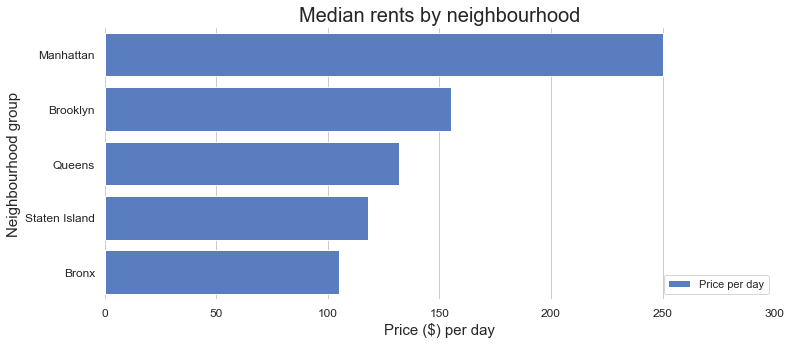

In [42]:
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(12, 5))

grouped_df = grouped_df.sort_values("price", ascending=False) # sorting the price values in descending order

sns.set_color_codes("muted") # setting color codes

# plotting a bar plot
bar1 = sns.barplot(x="price", y="neighbourhood_group_cleansed", data=grouped_df, label="Price per day", color="b") 


# Add a legend and informative axis label
ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(xlim=(0, 300))
sns.despine(left=True, bottom=True)

# formatting tick size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# setting title and label
plt.title("Median rents by neighbourhood", loc='center',fontsize=20)
plt.xlabel('Price ($) per day',fontsize=15)
plt.ylabel('Neighbourhood group',fontsize=15)

## 5. Inspecting Zipcodes

In [43]:
Airbnb.zipcode.value_counts()

11211         286
10002         167
11221         165
10009         156
11216         142
             ... 
10111           1
11432           1
11355           1
11219           1
10003-8623      1
Name: zipcode, Length: 176, dtype: int64

In [44]:
Airbnb.zipcode = Airbnb.zipcode.apply(lambda x: str(x)[0:5] if len(str(x)) > 5 else x) # formatting zipcode column
Airbnb.zipcode = Airbnb.zipcode.astype(str) # changing the zipcode to string format

Observations:

1. Some zipcode has 9 digit values. These needs to be changed to 5 digits to maintain uniformity.

## 6. Inspecting Availability_365

In [45]:
Airbnb.availability_365.value_counts() # inspecting the different values of availability_365 column

0      1053
0       220
365      78
364      42
122      24
       ... 
129       1
125       1
37        1
133       1
140       1
Name: availability_365, Length: 665, dtype: int64

In [46]:
Airbnb['availability_365'] = Airbnb['availability_365'].astype("int") # converting availability_365 column to int
x = Airbnb[Airbnb['availability_365'] < 1] # filtering values with availability_365 as 0 days
x.neighbourhood_group_cleansed.value_counts() # inspecting neighbourhoods with 0 values

Manhattan        620
Brooklyn         586
Queens            57
Bronx              7
Staten Island      3
Name: neighbourhood_group_cleansed, dtype: int64

Assumptions:

1. Availability_365 - This column specifies the no. of days the property is available for rent in a year. 
2. Not all properties listed by the host are available to rent for 365 days in a year. Listings may be available for only a certain amount of days in a year. Eg: A property may be available for only 200 days in a year.

Observations:

1. This column has 0 values. This needs to be corrected for futher analysis.
2. Most of the 0 values are from Manhattan and Brooklyn neighbourhoods.

Approach:

1. For columns with availability listed as 0, we will be computing the mean availability for each neighbourhood and transforming the 0 values with mean values.

### 6.1 Transforming availability_365 column

In [47]:
Airbnb.groupby('neighbourhood_group_cleansed')['availability_365'].mean()

neighbourhood_group_cleansed
Bronx            166.660377
Brooklyn         131.298514
Manhattan        140.091027
Queens           175.562130
Staten Island    178.700000
Name: availability_365, dtype: float64

In [48]:
# transforming availability_365 column

Airbnb['availability_365'] = Airbnb['availability_365'].replace(0, np.nan)
Airbnb['availability_365'] = Airbnb['availability_365'].fillna(Airbnb.groupby('neighbourhood_group_cleansed')['availability_365'].transform('mean'))
Airbnb['availability_365'] = Airbnb['availability_365'].apply(np.ceil)
Airbnb.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,9513511,https://www.airbnb.com/rooms/9513511,2.02E+13,5/3/17,Beautiful spacious & sunny 2 bedroom apartment!,This charming pre-war apartment building is lo...,Please excuse the amateur photos while I await...,This charming pre-war apartment building is lo...,none,This lovely LARGE 2 bedroom apartment is just ...,...,10,f,NaN,NaN,f,strict,f,f,1,0.4
1,5046189,https://www.airbnb.com/rooms/5046189,2.02E+13,5/4/17,Peace & Tranquility,IN THE HEART OF THE GREAT ITALIAN NEIGHBORHOOD...,NO OTHER LISTING IN NYC LIKE THIS . YOUR OWN H...,IN THE HEART OF THE GREAT ITALIAN NEIGHBORHOOD...,none,IN THE HEART OF THE GREAT ITALIAN NEIGHBORHOOD...,...,9,f,NaN,NaN,f,strict,f,f,2,1.15
2,4357134,https://www.airbnb.com/rooms/4357134,2.02E+13,5/5/17,Beautiful NY Gem,This is the perfect place for you and your fam...,NaN,This is the perfect place for you and your fam...,none,NaN,...,NaN,f,NaN,NaN,f,flexible,f,f,1,NaN
3,16027061,https://www.airbnb.com/rooms/16027061,2.02E+13,5/5/17,NYC finest apartment facing Easter River View!!!,My place is close to Bohemian Hall & Beer Gard...,My place is only 15 minutes away from Manhatta...,My place is close to Bohemian Hall & Beer Gard...,none,The peacefulness of Astoria Park while enjoyin...,...,NaN,f,NaN,NaN,t,flexible,f,f,1,NaN
4,11301089,https://www.airbnb.com/rooms/11301089,2.02E+13,5/4/17,Entire Apartment (Furnished) 2br in Astoria !,The Space ------------------------------------...,Beautiful Real 2 Bedroom Apartment in the Hear...,The Space ------------------------------------...,none,NaN,...,6,f,NaN,NaN,f,strict,t,t,2,1


## 7. Inspecting Room type

In [49]:
Airbnb.room_type.value_counts() #inspecting room_type

Entire home/apt    4581
Private room        301
Name: room_type, dtype: int64

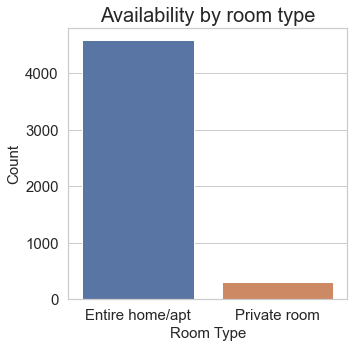

In [50]:
plt.figure(figsize=(5,5))
sns.countplot(data=Airbnb,x='room_type')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# setting title and labels
plt.title("Availability by room type", loc='center',fontsize=20)
plt.xlabel('Room Type',fontsize=15)
plt.ylabel('Count',fontsize=15)

plt.show()

Observations:

1. Most of the property listings are available to rent entirely.

# Selecting Features & Feature Engineering

### 1. Removing columns based on length of the values in the column

In [51]:
length = 20 # threshold length for removing columns based on the length of values in a column
Airbnb = remove_text_columns(Airbnb,length) # function call
Airbnb.shape

(4882, 75)

### 2. Removing columns based on certain patterns or column names

In [52]:
patterns = ['review','host','url','calendar','require','nights','scrape'] # patterns to look for in column names
Airbnb = remove_columns_w_patterns(Airbnb,patterns) # function call
Airbnb.shape

(4882, 40)

### 3. Removing columns based on null values % in a column

In [53]:
perc = 90.0 # threshold percentage for removing columns based on null values
Airbnb = remove_null_columns(Airbnb,perc) # function call
Airbnb.shape

(4882, 30)

In [54]:
Airbnb.dropna(inplace=True) # dropping remanining null values
Airbnb.shape

(4854, 30)

### 4. Manual selection of columns 

In [55]:
Airbnb = Airbnb[["neighbourhood_cleansed","neighbourhood_group_cleansed","room_type","property_type","bedrooms",
                 "city","state","latitude","longitude","zipcode","availability_365","price"]]
Airbnb.head()

,neighbourhood_cleansed,neighbourhood_group_cleansed,room_type,property_type,bedrooms,city,state,latitude,longitude,zipcode,availability_365,price
0,Allerton,Bronx,Entire home/apt,Apartment,2,Bronx,NY,40.85753243,-73.86605467,10462,193.0,130.0
1,Allerton,Bronx,Entire home/apt,Apartment,2,Bronx,NY,40.87054097,-73.84680709,10469,346.0,150.0
2,Ditmars Steinway,Queens,Entire home/apt,Apartment,2,New York,NY,40.77171541,-73.91768836,11102,212.0,200.0
3,Ditmars Steinway,Queens,Private room,Apartment,2,Queens,NY,40.7793726,-73.91553218,11102,180.0,250.0
4,Ditmars Steinway,Queens,Entire home/apt,Apartment,2,Astoria,NY,40.78080163,-73.91024629,11105,362.0,79.0


In [56]:
Airbnb.shape # final shape of Airbnb column after feature engineering

(4854, 12)

### 5. Feature Engineering - Creating Annual revenue column

In [57]:
Airbnb ['Annual Revenue'] = Airbnb ['price'] * 0.75 * Airbnb ['availability_365']
Airbnb.head()

,neighbourhood_cleansed,neighbourhood_group_cleansed,room_type,property_type,bedrooms,city,state,latitude,longitude,zipcode,availability_365,price,Annual Revenue
0,Allerton,Bronx,Entire home/apt,Apartment,2,Bronx,NY,40.85753243,-73.86605467,10462,193.0,130.0,18817.5
1,Allerton,Bronx,Entire home/apt,Apartment,2,Bronx,NY,40.87054097,-73.84680709,10469,346.0,150.0,38925.0
2,Ditmars Steinway,Queens,Entire home/apt,Apartment,2,New York,NY,40.77171541,-73.91768836,11102,212.0,200.0,31800.0
3,Ditmars Steinway,Queens,Private room,Apartment,2,Queens,NY,40.7793726,-73.91553218,11102,180.0,250.0,33750.0
4,Ditmars Steinway,Queens,Entire home/apt,Apartment,2,Astoria,NY,40.78080163,-73.91024629,11105,362.0,79.0,21448.5


# Filtering Zillow Data

In [58]:
cols = ['RegionID', 'City','Metro','CountyName','SizeRank'] # list to hold column values required to be filtered
state_z = ['NY'] # list to hold state values needed to be filtered

Zillow = filter_zillow_data(Zillow,state_z,cols) # function call
Zillow.head()

,zipcode,State,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,...,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
0,10013,NY,2245300.0,2264200.0,2301000.0,2328600.0,2337000.0,2341500.0,2335200.0,2316700.0,...,3347100,3305500,3261100,3244000.0,3231400,3183300,3160200,3193500,3262200,3316500
1,10014,NY,1611700.0,1631800.0,1648800.0,1670500.0,1674300.0,1657100.0,1659200.0,1661800.0,...,2480800,2443200,2430100,2452900.0,2451200,2441900,2460900,2494900,2498400,2491600
2,10011,NY,1438600.0,1434100.0,1439300.0,1437700.0,1430300.0,1426800.0,1427800.0,1424600.0,...,2354000,2355500,2352200,2332100.0,2313300,2319600,2342100,2365900,2419700,2480400
3,10003,NY,1381300.0,1380700.0,1368500.0,1372700.0,1378000.0,1361700.0,1357800.0,1364400.0,...,1932800,1930400,1937500,1935100.0,1915700,1916500,1965700,2045300,2109100,2147000
4,10023,NY,1399100.0,1399800.0,1389300.0,1384700.0,1380900.0,1367900.0,1365400.0,1375100.0,...,1993500,1980700,1960900,1951300.0,1937800,1929800,1955000,2022400,2095000,2142300


In [59]:
Zillow.shape

(475, 80)

# Joining Airbnb and Zillow

In [60]:
# creating a dataframe with zipcode and latest available median price from zillow data
Zillow_j = Zillow[['zipcode','2017-06']]

In [61]:
# join airbnb and zillow latest list price
Airbnb_zillow = join_zillow_airbnb(Airbnb,Zillow_j,'inner','zipcode') # function call
Airbnb_zillow.rename(columns={'2017-06': 'Median_price_latest'}, inplace=True) # renaming 2017-06 column
Airbnb_zillow.head()

,neighbourhood_cleansed,neighbourhood_group_cleansed,room_type,property_type,bedrooms,city,state,latitude,longitude,zipcode,availability_365,price,Annual Revenue,Median_price_latest
0,Arrochar,Staten Island,Entire home/apt,House,2,Staten Island,NY,40.59526454,-74.06471486,10305,199.0,120.0,17910.00,425100
1,Arrochar,Staten Island,Entire home/apt,Apartment,2,Staten Island,NY,40.59346945,-74.06913708,10305,197.0,110.0,16252.50,425100
2,Arrochar,Staten Island,Entire home/apt,House,2,Staten Island,NY,40.59652785,-74.06371161,10305,199.0,150.0,22387.50,425100
3,Concord,Staten Island,Entire home/apt,Apartment,2,Staten Island,NY,40.6056,-74.0827,10305,83.0,150.0,9337.50,425100
4,Concord,Staten Island,Entire home/apt,House,2,Staten Island,NY,40.6037,-74.0806,10305,49.0,129.0,4740.75,425100


# Converting wide data to long format

In [62]:
#converting wide data to long form

ziplist = Airbnb_zillow['zipcode'].unique().tolist() # list to hold zip values to be filtered from zillow data

zillow_transpose_long = zillow_transpose_long(Zillow,ziplist) # function call

In [63]:
zillow_transpose_long.head() # inspecting the long format time series data

,Time,10013,10014,10011,10003,10023,10028,10022,10021,10128,...,11217,11231,11215,11234,10305,10308,11434,10312,10306,10304
0,2011-01,2.2453e+06,1.6117e+06,1.4386e+06,1.3813e+06,1.3991e+06,1.3107e+06,1.3766e+06,1.2225e+06,974500,...,628500,642900,573100,387100,316400,322400,276800,293900,289400,254000
1,2011-02,2.2642e+06,1.6318e+06,1.4341e+06,1.3807e+06,1.3998e+06,1.3182e+06,1.3724e+06,1.2306e+06,965200,...,630900,642800,579600,385300,315400,322000,263700,293500,288400,253700
2,2011-03,2.301e+06,1.6488e+06,1.4393e+06,1.3685e+06,1.3893e+06,1.3219e+06,1.3781e+06,1.2474e+06,963200,...,635000,643000,588800,380700,313000,320600,251400,291700,288200,253000
3,2011-04,2.3286e+06,1.6705e+06,1.4377e+06,1.3727e+06,1.3847e+06,1.3092e+06,1.3846e+06,1.258e+06,959200,...,636700,646800,592200,377000,308700,319200,245500,289300,285700,251400
4,2011-05,2.337e+06,1.6743e+06,1.4303e+06,1.378e+06,1.3809e+06,1.2987e+06,1.3896e+06,1.2508e+06,964400,...,635600,651700,592700,377900,306000,318300,243900,287400,281900,250100


# Visualizing the zipcode price distributions through a histogram

array([[<AxesSubplot:title={'center':'10013'}>,
        <AxesSubplot:title={'center':'10014'}>,
        <AxesSubplot:title={'center':'10011'}>,
        <AxesSubplot:title={'center':'10003'}>,
        <AxesSubplot:title={'center':'10023'}>],
       [<AxesSubplot:title={'center':'10028'}>,
        <AxesSubplot:title={'center':'10022'}>,
        <AxesSubplot:title={'center':'10021'}>,
        <AxesSubplot:title={'center':'10128'}>,
        <AxesSubplot:title={'center':'10036'}>],
       [<AxesSubplot:title={'center':'10025'}>,
        <AxesSubplot:title={'center':'11201'}>,
        <AxesSubplot:title={'center':'11217'}>,
        <AxesSubplot:title={'center':'11231'}>,
        <AxesSubplot:title={'center':'11215'}>],
       [<AxesSubplot:title={'center':'11234'}>,
        <AxesSubplot:title={'center':'10305'}>,
        <AxesSubplot:title={'center':'10308'}>,
        <AxesSubplot:title={'center':'11434'}>,
        <AxesSubplot:title={'center':'10312'}>],
       [<AxesSubplot:title={'center'

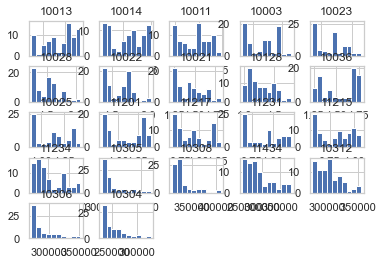

In [64]:
hist = zillow_transpose_long.iloc[:,1:].astype(int)
hist.hist()

Observations:
   
1. Most of the columns are positively skewed. In such scenarios, median is a better measure of central tendency than mean since mean > median and it is resistent to outliers compared to mean.

# Visualizing the trends in Median List Prices by Zipcodes through time

<Figure size 1080x1080 with 0 Axes>

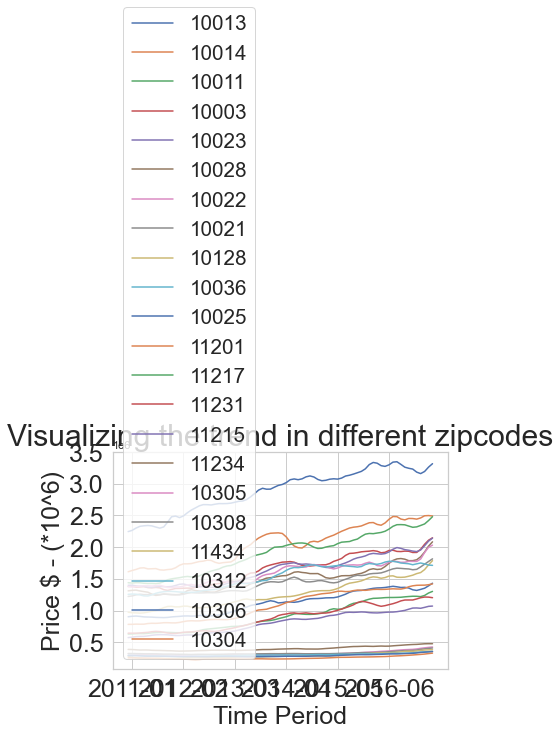

In [65]:
plt.figure(figsize=(15,15))
zillow_transpose_long.plot()

plt.xticks(zillow_transpose_long.index+1, zillow_transpose_long['Time'],fontsize=25)
plt.yticks(fontsize=25)

plt.title("Visualizing the trend in different zipcodes", loc='center',fontsize=30)
plt.xlabel('Time Period',fontsize=25)
plt.ylabel('Price $ - (*10^6)',fontsize=25)
plt.locator_params(axis="x", nbins=6)
plt.legend(fontsize='xx-large')

plt.show()

# Time Series forecasting using Prophet

In [66]:
future = ['2022-06-01','2027-06-01','2032-06-01'] # list to hold future time periods for prediction
f_zip = timeseries_forecast(zillow_transpose_long,future) # function call
f_zip.head()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

,2022-06,2027-06,2032-06,zipcode
0,3.44961e+06,3.61978e+06,3.75452e+06,10013
0,3.24763e+06,3.97424e+06,4.69178e+06,10014
0,3.35648e+06,4.27815e+06,5.17868e+06,10011
0,2.59426e+06,3.13519e+06,3.67631e+06,10003
0,2.85661e+06,3.64929e+06,4.42749e+06,10023


# Joining the forecasted house prices with Airbnb Zillow dataframe

In [67]:
# joining the forecasted house prices with Airbnb Zillow dataframe
forecast = join_zillow_airbnb(Airbnb_zillow,f_zip,'inner','zipcode')
forecast.rename(columns={'2022-06': 'forecast_5yr','2027-06': 'forecast_10yr','2032-06': 'forecast_15yr'}, inplace=True)
forecast.head()

,neighbourhood_cleansed,neighbourhood_group_cleansed,room_type,property_type,bedrooms,city,state,latitude,longitude,zipcode,availability_365,price,Annual Revenue,Median_price_latest,forecast_5yr,forecast_10yr,forecast_15yr
0,Arrochar,Staten Island,Entire home/apt,House,2,Staten Island,NY,40.59526454,-74.06471486,10305,199.0,120.0,17910.00,425100,710289,1.00125e+06,1.29133e+06
1,Arrochar,Staten Island,Entire home/apt,Apartment,2,Staten Island,NY,40.59346945,-74.06913708,10305,197.0,110.0,16252.50,425100,710289,1.00125e+06,1.29133e+06
2,Arrochar,Staten Island,Entire home/apt,House,2,Staten Island,NY,40.59652785,-74.06371161,10305,199.0,150.0,22387.50,425100,710289,1.00125e+06,1.29133e+06
3,Concord,Staten Island,Entire home/apt,Apartment,2,Staten Island,NY,40.6056,-74.0827,10305,83.0,150.0,9337.50,425100,710289,1.00125e+06,1.29133e+06
4,Concord,Staten Island,Entire home/apt,House,2,Staten Island,NY,40.6037,-74.0806,10305,49.0,129.0,4740.75,425100,710289,1.00125e+06,1.29133e+06


In [68]:
# creating a dataframe to count of property listings for each zipcode
listings = forecast.zipcode.value_counts()
listings = pd.DataFrame(listings)
listings.reset_index(level=0, inplace=True)
listings.rename(columns={'index': 'zipcode','zipcode': 'count'}, inplace=True)
listings.head()

,zipcode,count
0,11215,140
1,10003,132
2,10025,111
3,10036,107
4,10011,101


Text(0, 0.5, 'No of listings')

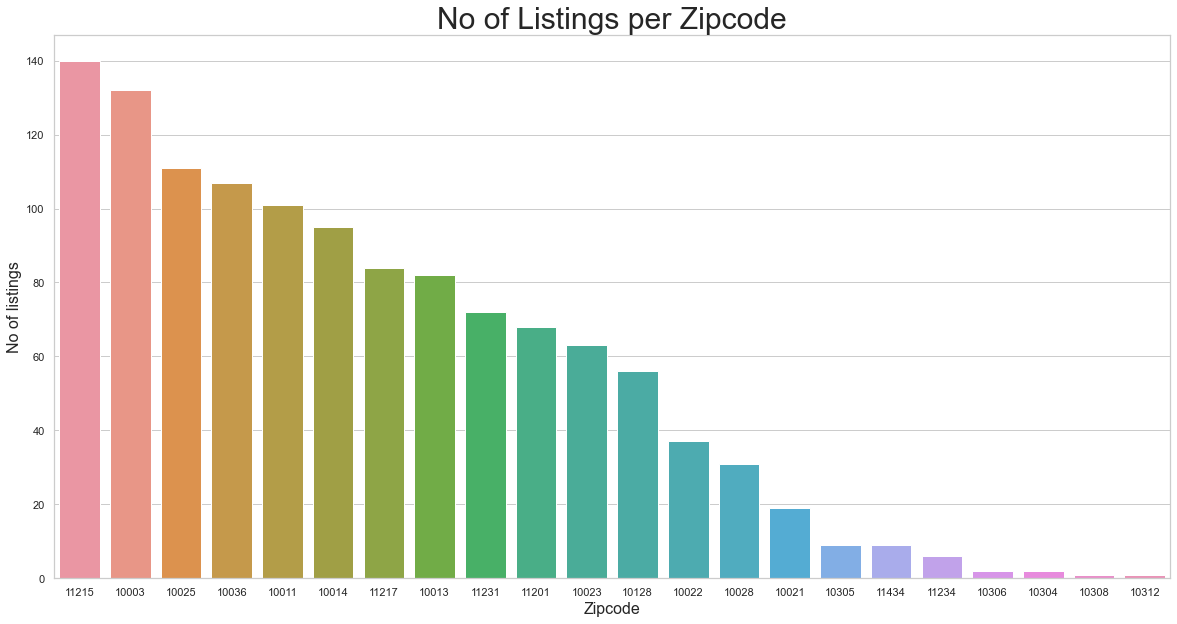

In [69]:
# visualizing the No of Listings per Zipcode using barplot

plt.figure(figsize=(20,10))
sns.barplot(x = listings['zipcode'], y = listings ['count'])
plt.title("No of Listings per Zipcode", fontsize=30)
plt.xlabel("Zipcode", fontsize=16)
plt.ylabel("No of listings", fontsize=16)

Obdervations:

1. Zipcodes like 10308, 10312, 10306, 10304, 11234, 11434, 10305 have lesser than 15 listings.
2. Zipcodes like 11215, 10003, 10025, 10036 have more than a 100 listings.

# Final dataframes after computing Payback period and 5 year ROI

In [70]:
# dataframe after computing payback period
payback = breakeven(forecast,listings,15,5) # function call
payback.head()

NameError: name 'df1' is not defined

In [ ]:
# dataframe after computing 5 year ROI
roi = roi(forecast,listings,15,5) # function call
roi.head()

# Visualization

In [ ]:
plt.grid(b=None)

ordered_payback = payback.sort_values(by='Payback_period',ascending = False).reset_index(drop=True)
my_range = range(1, len(ordered_payback.index) + 1)

plt.hlines(y=my_range, xmin=0, xmax=ordered_payback['Payback_period'], color='skyblue') # plotting the horizontal line
plt.plot(ordered_payback['Payback_period'], my_range, 'o', markersize=11) # plotting the marker

# setting ticks and labels
plt.yticks(ordered_payback.index+1, ordered_payback['zipcode'],fontsize=25)
plt.xticks(fontsize=25)

plt.title("Time to Break Even", loc='center',fontsize=30)
plt.xlabel('Payback period in Years',fontsize=25)
plt.ylabel('Zipcode',fontsize=25)

# drawing the average line
plt.axvline(ordered_payback['Payback_period'].mean(), color='green', linewidth=2, linestyle ="--")

# setting the legend
l = ['Payback period','Mean Payback period']
plt.legend(l, fontsize = 'large', loc=1)

plt.show()

In [ ]:
plt.grid(b=None) # setting the background to white

# plotting the scatter plot
sns.scatterplot(x=payback['Payback_period'], y=payback['count'], hue=payback['zipcode'], s=100)

annotate_scatterplot(payback.Payback_period, payback['count'], payback.zipcode, plt.gca()) # function call

# setting ticks and labels
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.title("Payback Period vs No of listings", loc='center',fontsize=30)
plt.xlabel('Payback period in Years',fontsize=25)
plt.ylabel('No of listings',fontsize=25)
plt.legend(fontsize='xx-large')

## Based on Payback Period: 

## Focus on zipcodes 10036, 10022, 11231.

In [ ]:
plt.grid(b=None)

ordered_df = roi.sort_values(by='ROI').reset_index(drop=True)
my_range = range(1, len(ordered_df.index) + 1)

plt.hlines(y=my_range, xmin=0, xmax=ordered_df['ROI'], color='skyblue') # plotting the horizontal line
plt.plot(ordered_df['ROI'], my_range, 'o', markersize=11) # plotting the marker

# setting ticks and label
plt.yticks(ordered_df.index+1, ordered_df['zipcode'],fontsize=25)
plt.xticks(fontsize=25)

plt.title("ROI by Zipcode", loc='center',fontsize=30)
plt.xlabel('ROI %',fontsize=25)
plt.ylabel('Zipcode',fontsize=25)

# drawing the mean line
plt.axvline(ordered_df['ROI'].mean(), color='green', linewidth=2, linestyle ="--")

# setting legend
leg = ['ROI','ROI Mean']
plt.legend(leg, fontsize = 'large', loc=4)

plt.show()

In [ ]:
plt.grid(b=None)

sns.scatterplot(x=roi['ROI'], y=roi['count'], hue=roi['zipcode'], s=100) # scatter plot

annotate_scatterplot(roi.ROI, roi['count'], roi.zipcode, plt.gca()) # function call

# setting ticks and labels
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.title("No of listings vs 5 year ROI", loc='center',fontsize=30)
plt.xlabel('ROI %',fontsize=25)
plt.ylabel('No of Listings',fontsize=25)
plt.legend(fontsize='xx-large')

## Based on 5 year ROI: 

## Focus on zipcodes 10028, 11231, 10128.

# Future Steps

1. Square footage information will help us understand price better.98% listings missing square footage information
   Next step : Richer data or extrapolation using ML techniques

2. Weekly prices and multi-day bookings not incorporated in analysis

3. Only 24 New York zip codes in Zillow data restricting analysis 

4. Prices taken based on a single point in time. Historical price data will help analyze price trends

5. Queens and Staten Island (less listings) -Social media analysis to understand true demand!